# 3層ANNによる非線形歪補償
最も基本的な、入力層・中間層・出力層からなる3層ANNによる補償

In [1]:
#import
import sys
import os
import time
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

sys.path.append('../')
from pyopt.util import save_pickle, load_pickle

# 1. Preprocessing

## 1.1 データの整形

In [2]:
def data_shaping(input_signal, signal, sampling, tap, max_tap, n):
    """
    input_signal: 伝送前の信号
    signal: 伝送後の信号
    max_tap: 最大の同時入力シンボル数
    tap: 同時入力シンボル数
    
    signal = [x_0, x_1, ... , x_(n-1)]
      |
      |
      v
    x = [[x_0, x_1, ... , x_tap-1],
            [x_1, x_2, ..., x_tap],
                   .
                   .
                   .
            [x_(n-tap), x_(n-tap+1), ..., x(n-1)]]
      |
      |
      v
    x = [[i_0, q_0, i_1, q_1, ... , i_(tap-1), q_(tap-1)],
            [i_1, q_1, i_2, q_2, ... , i_tap, q_tap],
                   .
                   .
                   .
            [i_(n-tap), q_(n-tap), i_(n-tap+1), q_(n-tap+1), ..., i_(n-1), q_(n-1)]] (batch, input_dim) input_dim = tap * 2
    
    y  (batch, output_dim) output_dim = 2
    """
    
    x = np.zeros((len(input_signal) // n - (max_tap - 1), sampling * tap * 2), dtype=float)
    y = np.zeros((len(input_signal) // n - (max_tap - 1), 2), dtype=float)
    if sampling == 1:
        for i, center in enumerate(range(max_tap // 2, len(input_signal) // n - max_tap // 2)):
            for j, symbol in enumerate(range(tap)):
                x[i, j * 2] = signal[n * (center - tap // 2 + j) + n // 2].real
                x[i, j * 2 + 1] = signal[n * (center - tap // 2 + j) + n // 2].imag
            y[i, 0] = input_signal[n // 2 + n * center].real
            y[i, 1] = input_signal[n // 2 + n * center].imag
    else:
        for i, center in enumerate(range(max_tap // 2, len(input_signal) // n - max_tap // 2)):
            for j, symbol in enumerate(range(tap)):
                for k, sample in enumerate([round(_ * n / sampling) for _ in range(sampling)]):
                    x[i, j * sampling * 2 + k * 2] = signal[n * (center - tap // 2 + j) + sample].real
                    x[i, j * sampling * 2 + k * 2 + 1] = signal[n * (center - tap // 2 + j) + sample].imag
            y[i, 0] = input_signal[n // 2 + n * center].real
            y[i, 1] = input_signal[n // 2 + n * center].imag
    return x, y

In [41]:
#動作確認
sampling = 3
tap = 51
max_tap = 501

df_dir = '../data/input/prbs.csv'
df = pd.read_csv(df_dir, index_col=0)  # dataframe読み込み
condition = (df['N']==13) & (df['itr']==1) & (df['form']=='RZ16QAM') & (df['n']==32) & (df['equalize']==False) & (df['baudrate']==28) & (df['PdBm']==1)
sgnl = load_pickle(df[condition].iloc[0]['data_path'])  # dataframeから条件と合う行を取得し,pickleの保存先(data_path)にアクセス
lc = sgnl.linear_compensation(500, sgnl.signal['x_500'])
x, y = data_shaping(sgnl.signal['x_0'], lc, sampling, tap, max_tap, 32)  # ANNに入力できるようにデータを整形

print('x size: ', x.shape)
print('y size: ', y.shape)
print(x[0])
print(y[0])

x size:  (1548, 306)
y size:  (1548, 2)
[ 3.32045355e+02 -2.75519561e+02  4.60798224e+04 -4.66110424e+04
  4.21489600e+04 -4.67112229e+04 -2.32276054e+03  3.07608289e+03
 -4.51780310e+04 -3.78998500e+04 -4.76122063e+04 -4.59213781e+04
 -4.30312746e+03  5.16168853e+02 -4.71965222e+04  5.23620751e+04
 -4.90156310e+04  4.78102035e+04 -2.11024062e+03 -1.27503787e+03
  3.04625620e+04  7.02327156e+03  3.32956474e+04  4.77377947e+03
 -5.24451737e+02 -3.21177869e+03 -4.58767073e+04  4.41633798e+04
 -4.02995504e+04  4.46267546e+04  3.18925268e+03 -2.47473771e+02
 -8.17551172e+04 -2.76568296e+04 -8.44275255e+04 -2.73195821e+04
 -1.24965302e+01  6.39903865e+02  6.71308196e+04 -1.32647465e+04
  6.34534868e+04 -1.13760122e+04  1.77276951e+03 -1.29113052e+03
  1.22564189e+04  6.37524278e+04  1.17292734e+04  6.21289954e+04
  3.36816206e+02  1.70855464e+02  9.66458066e+03  7.04518322e+04
  8.50997421e+03  6.33176591e+04  4.41145849e+02  3.15510735e+03
 -2.46742537e+04 -7.34993019e+03 -2.48112644e+04 -

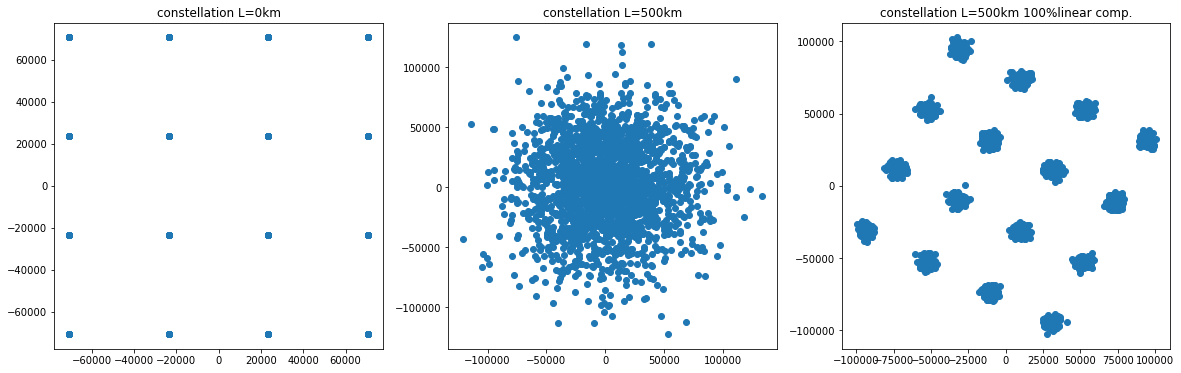

In [362]:
fig = plt.figure(figsize=(20, 6))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.plot(sgnl.signal['x_0'][16::32].real, sgnl.signal['x_0'][16::32].imag, 'o')
ax1.set_title('constellation L=0km')

ax2.plot(sgnl.signal['x_500'][16::32].real, sgnl.signal['x_500'][16::32].imag, 'o')
ax2.set_title('constellation L=500km')

ax3.plot(lc[16::32].real, lc[16::32].imag, 'o')
ax3.set_title('constellation L=500km 100%linear comp.');

## 1.2 平均,標準偏差の計算

In [363]:
mean = np.mean(x)
std = np.std(x)

print('mean: ', mean)
print('std: ', std)

mean:  1053.2765739234778
std:  45950.91990246874


# 2. Dataset定義

In [3]:
class Dataset(data.Dataset):
    def __init__(self, x, y, mean, std):
        self.x, self.y, self.mean, self.std = x, y, mean, std
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        
        x = (x - self.mean) / self.std
        y = (y - self.mean) / self.std
        return torch.Tensor(x), torch.Tensor(y)

In [365]:
#動作確認
train_dataset = Dataset(x=x, y=y, mean=mean, std=std)

index = 0
x_normalized, y_normalized = train_dataset.__getitem__(index)
x_array = x_normalized.detach().numpy()

print('mean: ', np.mean(x_array))
print('std: ', np.std(x_array))
print(x_normalized)
print(y_normalized)

mean:  0.03935981
std:  0.9990706
tensor([ 0.1744, -0.6305,  0.2542, -0.6643,  0.1498, -0.5816,  0.0621, -0.5425,
         0.0989, -0.6737,  0.2707, -0.7228,  0.5879, -1.8054,  0.5348, -1.8017,
         1.4744, -0.2758,  1.3161, -0.2410,  1.7203,  0.5624,  1.7064,  0.5428,
        -0.6141, -0.2306, -0.6262, -0.2575,  1.8602,  0.5342,  1.7956,  0.5487,
        -0.6887,  1.8563, -0.6805,  1.8318,  1.7734,  0.5692,  1.8469,  0.4622,
         0.1909, -0.5909,  0.1415, -0.5378,  1.0256, -1.0119,  0.9728, -1.0440,
        -0.6777,  1.8656, -0.6665,  1.8169, -0.6359,  1.8979, -0.5313,  1.8349,
         0.6288,  0.2404,  0.5757,  0.2335,  0.0350,  1.3691,  0.1842,  1.3636,
         0.5889,  0.1623,  0.4928,  0.1936, -1.5795,  0.1956, -1.4978,  0.2328,
        -1.4946,  0.1612, -1.4766,  0.1482,  1.3541, -0.1792,  1.3138, -0.2410,
         0.6693,  0.0918,  0.5981,  0.1094,  0.1877, -0.6334,  0.1373, -0.6857,
         0.1281, -0.7059,  0.1780, -0.6310, -1.4345,  0.1194, -1.4554,  0.1487,
      

In [366]:
batch_size = 100

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

dataloaders_dict = {'train': train_dataloader}

# 3. Model定義

In [4]:
class ANN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_neuron, activation):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_neuron)
        self.fc2 = nn.Linear(hidden_neuron, output_dim)
        if activation == 'ReLU':
            self.activation = F.relu
        elif activation == 'Sigmoid':
            self.activation = torch.sigmoid
    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

In [368]:
#動作確認
hidden_neuron = 300
activation = 'Sigmoid'
device = torch.device('cpu') # 'cuda' if torch.cuda.is_available() else 
print('Device available now:', device)

model = ANN(input_dim=sampling*tap*2, output_dim=2, hidden_neuron=hidden_neuron, activation=activation).to(device)
for x, y in train_dataloader:
    print(x.shape)
    output = model(x)
    print(output[:6])
    break

Device available now: cpu
torch.Size([100, 204])
tensor([[-0.0459,  0.0695],
        [ 0.0309, -0.0350],
        [-0.0725,  0.1273],
        [-0.0221,  0.0749],
        [-0.1046,  0.1126],
        [-0.0534,  0.1939]], grad_fn=<SliceBackward>)


# 4. train定義

In [5]:
def evm_score(y_pred, y_true):
    tmp = 0
    for i in range(len(y_pred)):
        tmp += ((y_pred[i][0] - y_true[i][0]) ** 2 + (y_pred[i][1] - y_true[i][1]) ** 2) / (y_true[i][0] ** 2 + y_true[i][1] ** 2)
    evm = torch.sqrt(tmp / len(y_pred))
    return evm

In [6]:
def train_model(device, model, dataloaders_dict, criterion, optimizer, epochs, epochs_section=None):
    """
    epochs_section: [start_epoch, end_epoch]
    """
    
    for epoch in range(epochs):
        if epochs_section is not None:
            epoch += epochs_section[0]
            end_epoch = epochs_section[1]
        else:
            end_epoch = epochs
        
        start_time = time.time()
        
        for phase in dataloaders_dict.keys():
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            epoch_loss = 0.0
            epoch_evms = 0.0
            
            for x, y in dataloaders_dict[phase]:
                x = x.to(device)
                y = y.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(x)
                    loss = criterion(outputs, y)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    epoch_loss += loss.item() * x.size(0)
                    epoch_evms += (evm_score(outputs, y)) ** 2 * x.size(0)
            
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_evm = torch.sqrt(epoch_evms / len(dataloaders_dict[phase].dataset)) * 100
            
            duration = str(datetime.timedelta(seconds=time.time() - start_time))[:7]
            print('{} | Epoch: {}/{} | {} Loss: {:.4} | EVM: {:.4}'.format(duration, epoch + 1, end_epoch, phase, epoch_loss, epoch_evm))
    return model

In [313]:
#動作確認
epochs = 5
lr = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=lr)

train_model(device=device, model=model, dataloaders_dict=dataloaders_dict, criterion=criterion, optimizer=optimizer, epochs=epochs);

0:00:00 | Epoch: 1/5 | train Loss: 0.9742 | EVM: 99.0
0:00:00 | Epoch: 2/5 | train Loss: 0.8474 | EVM: 92.44
0:00:00 | Epoch: 3/5 | train Loss: 0.733 | EVM: 86.64
0:00:00 | Epoch: 4/5 | train Loss: 0.6156 | EVM: 79.79
0:00:00 | Epoch: 5/5 | train Loss: 0.4839 | EVM: 71.19


# 5. 実行

In [7]:
def load_signal(signal_info, trans_condition, lc, sampling, tap, max_tap, n, Lmax):
    if signal_info['signal_type'] == 'prbs':
        return load_prbs(signal_info, trans_condition, lc, sampling, tap, max_tap, n, Lmax)
    elif signal_info['signal_type'] == 'random':
        return load_random(signal_info, trans_condition, lc, sampling, tap, max_tap, n, Lmax)
    elif signal_info['signal_type'] == 'image':
        return load_image(signal_info, trans_condition, lc, sampling, tap, max_tap, n, Lmax)

In [8]:
def load_prbs(signal_info, trans_condition, lc, sampling, tap, max_tap, n, Lmax):
    N = signal_info['N']
    itr = signal_info['itr']
    signal_condition = 'N=='+str(N)+'&itr=='+str(itr)
    signal_list = [N, itr] + [None] * 6
    
    # prbs.csvをpandasで読み込む
    t_df_dir = '../data/input/'
    t_df = pd.read_csv(t_df_dir + 'prbs.csv', index_col=0)
    
    # prbs.csvにおいて、指定した伝送条件を見たす行を抜き出す
    t_query = t_df.query(signal_condition + '&' + trans_condition)
    
    # if prbs.csvに指定した伝送条件がない or Lmax以外は満たすがLmaxだけ指定した条件未満: 何もしない if ある: 続ける
    if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
        print('指定された伝送条件の信号が存在しません')
        return
    else:
        # 伝送信号を学習データに整形する
        sgnl = load_pickle(t_query.iloc[0]['data_path'])
        if lc:
            sgnl_distorted = sgnl.linear_compensation(Lmax, sgnl.signal['x_' + str(Lmax)])
        else:
            sgnl_distorted = sgnl.signal['x_' + str(Lmax)]
        x, y = data_shaping(sgnl.signal['x_0'], sgnl_distorted, sampling, tap, max_tap, n)
        return x, y, signal_condition, signal_list

In [9]:
def load_random(signal_info, trans_condition, lc, sampling, tap, max_tap, n, Lmax):
    seed = signal_info['seed']
    bit_num = signal_info['bit_num']
    signal_condition = 'seed=='+str(seed)+'&bit_num=='+str(bit_num)
    signal_list = [None] * 2 + [seed, bit_num] + [None] * 4
    
    # random.csvをpandasで読み込む
    t_df_dir = '../data/input/'
    t_df = pd.read_csv(t_df_dir + 'random.csv', index_col=0)
    
    # random.csvにおいて、指定した伝送条件を見たす行を抜き出す
    t_query = t_df.query(signal_condition + '&' + trans_condition)
    
    # if random.csvに指定した伝送条件がない or Lmax以外は満たすがLmaxだけ指定した条件未満: 何もしない if ある: 続ける
    if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
        print('指定された伝送条件の信号が存在しません')
        return
    else:
        # 伝送信号を学習データに整形する
        sgnl = load_pickle(t_query.iloc[0]['data_path'])
        if lc:
            sgnl_distorted = sgnl.linear_compensation(Lmax, sgnl.signal['x_' + str(Lmax)])
        else:
            sgnl_distorted = sgnl.signal['x_' + str(Lmax)]
        x, y = data_shaping(sgnl.signal['x_0'], sgnl_distorted, sampling, tap, max_tap, n)
        return x, y, signal_condition, signal_list

In [10]:
def load_image(signal_info, trans_condition, lc, sampling, tap, max_tap, n, Lmax):
    target_dir = signal_info['target_dir']
    step = signal_info['step']
    image_number = signal_info['image_number']
    image_number_split = image_number.split(', ')
    ebtb = signal_info['ebtb']
    signal_condition = 'target_dir=="'+str(target_dir)+'"&step=='+str(step)+'&image_number=="'+image_number+'"&ebtb=='+str(ebtb)
    signal_list = [None] * 4 + [target_dir, step, image_number, ebtb]
    
    # image.csvをpandasで読み込む
    t_df_dir = '../data/input/'
    t_df = pd.read_csv(t_df_dir + 'image.csv', index_col=0)
    
    x = None
    y = None
    for i in range(len(image_number_split)):
        # image.csvにおいて、指定した伝送条件を見たす行を抜き出す
        t_query = t_df.query('target_dir=="'+str(target_dir)+'"&step=='+str(step)+'&image_number=='+image_number_split[i]+'&ebtb=='+str(ebtb) + '&' + trans_condition)
        
        # if image.csvに指定した伝送条件がない or Lmax以外は満たすがLmaxだけ指定した条件未満: 何もしない if ある: 続ける
        if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
            print('指定された伝送条件の信号が存在しません')
            return
        else:
            # 伝送信号を学習データに整形する
            sgnl = load_pickle(t_query.iloc[0]['data_path'])
            if lc:
                sgnl_distorted = sgnl.linear_compensation(Lmax, sgnl.signal['x_' + str(Lmax)])
            else:
                sgnl_distorted = sgnl.signal['x_' + str(Lmax)]
            if len(sgnl.signal['x_0']) // n - (max_tap - 1) > 0:
                x_tmp, y_tmp = data_shaping(sgnl.signal['x_0'], sgnl_distorted, sampling, tap, max_tap, n)
            if x is None:
                x = x_tmp
                y = y_tmp
            else:
                x = np.concatenate([x, x_tmp])
                y = np.concatenate([y, y_tmp])
    return x, y, signal_condition, signal_list

In [11]:
def load_model(learn_condition, trans_condition, signal_condition, device, sampling, tap, neuron, epochs, activation, Lmax):
    # if ANN.csv がある: pandasで読み込む if ANN.csvがない: 新しいDataFrameを作る
    l_df_dir = '../data/params/ANN.csv'
    if os.path.exists(l_df_dir):
        l_df = pd.read_csv(l_df_dir, index_col=0)
    else:
        cols = ['linear_compensation', 'sampling', 'tap', 'max_tap', 'batch_size', 'neuron', 'epochs', 'learning_rate', 'activation', 'N', 'itr', 'seed', 'bit_num', 'target_dir', 'step', 'image_number', 'ebtb', 'form', 'n', 'equalize', 'baudrate', 'PdBm', 'Ledfa', 'stepedfa', 'gamma', 'D', 'Alpha', 'NF', 'Lmax', 'ase', 'params_path', 'train_samples']
        l_df = pd.DataFrame(index=[], columns=cols)
        l_df.to_csv(l_df_dir)

    # ANN.csvにおいて、指定した条件を満たす行だけqueryとして抜き出す
    l_query = l_df.query(learn_condition + '&' + signal_condition + '&' + trans_condition + '&Lmax=='+str(Lmax))
    
    #if epochsを含む指定された条件を満たす結果がある: 何もしない
    if len(l_query) > 0 and l_query['epochs'].max() >= epochs:
        print('指定された条件の学習結果はすでに存在します')
        return None, None, None
    else:
        # if epochs以外の指定された条件を満たす結果がある: パラメータを読み込む if ない: 新しくモデルを作成する
        if len(l_query) > 0:
            index = l_query['epochs'].idxmax()
            trained_epochs = l_query['epochs'][index]
            model = ANN(input_dim=sampling*tap*2, output_dim=2, hidden_neuron=neuron, activation=activation).to(device)
            model.load_state_dict(torch.load(l_query['params_path'][index]))
        else:
            trained_epochs = 0
            model = ANN(input_dim=sampling*tap*2, output_dim=2, hidden_neuron=neuron, activation=activation).to(device)
    return model, l_df_dir, trained_epochs

In [12]:
#結果と条件を保存しない
def train_ann(model_info, signal_info, tap, PdBm):
    device = torch.device('cpu') #'cuda' if torch.cuda.is_available() else 
    print('Device available now:', device)
    
    lc = model_info['linear_compensation']
    sampling = model_info['sampling']
    #tap = model_info['tap']
    batch_size = model_info['batch_size']
    neuron = model_info['neuron']
    epochs = model_info['epochs']
    lr = model_info['lr']
    activation = model_info['activation']
    form = model_info['form']
    #PdBm = model_info['PdBm']
    Lmax = model_info['Lmax']

    max_tap = 501
    n = 32  # 1シンボルあたりのサンプリング数[/symbol]
    equalize = False  # 各シンボル数を均等にするか
    baudrate = 28  # ボーレート[GBaud]
    Ledfa = 100  # EDFAスパン[km]
    stepedfa = 30  # SSFMの繰り返し計算ステップ数
    gamma = 2.8  # 非線形係数[/W/km]
    D = 16  # 分散パラメータ[ps/nm/km]
    Alpha = 0.16  # 伝送損失[dB/km]
    NF = 4  # ASE雑音指数[dB]
    ase = True  # ASE雑音を考慮するか

    # 指定した学習条件と伝送条件
    trans_condition = 'form=="'+str(form)+'"&n=='+str(n)+'&equalize=='+str(equalize)+'&baudrate=='+str(baudrate)+'&PdBm=='+str(PdBm)+'&Ledfa=='+str(Ledfa)+'&stepedfa=='+str(stepedfa)+'&\
                                    gamma=='+str(gamma)+'&D=='+str(D)+'&Alpha=='+str(Alpha)+'&NF=='+str(NF)+'&ase=='+str(ase)

    x, y, _, _ = load_signal(signal_info, trans_condition, lc, sampling, tap, max_tap, n, Lmax)
    
    # 平均,標準偏差の計算
    mean = np.mean(x)
    std = np.std(x)
    
    model = ANN(input_dim=sampling*tap*2, output_dim=2, hidden_neuron=neuron, activation=activation).to(device)

    # dataset, dataloaderの作成
    train_dataset = Dataset(x=x, y=y, mean=mean, std=std)
    train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dataloaders_dict = {'train': train_dataloader}

    # 損失関数, オプティマイザの作成
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params=model.parameters(), lr=lr)

    # モデルのトレーニング
    model = train_model(device=device, model=model, dataloaders_dict=dataloaders_dict, criterion=criterion, optimizer=optimizer, epochs=epochs)

In [13]:
#結果と条件を../data/params/ANN.csvに保存する
def train_ann_with_save(model_info, signal_info, tap, PdBm):
    device = torch.device('cpu') #'cuda' if torch.cuda.is_available() else 
    print('Device available now:', device)
    
    lc = model_info['linear_compensation']
    sampling = model_info['sampling']
    #tap = model_info['tap']
    batch_size = model_info['batch_size']
    neuron = model_info['neuron']
    epochs = model_info['epochs']
    lr = model_info['lr']
    activation = model_info['activation']
    form = model_info['form']
    #PdBm = model_info['PdBm']
    Lmax = model_info['Lmax']
    
    max_tap = 501
    n = 32  # 1シンボルあたりのサンプリング数[/symbol]
    equalize = False  # 各シンボル数を均等にするか
    baudrate = 28  # ボーレート[GBaud]
    Ledfa = 100  # EDFAスパン[km]
    stepedfa = 30  # SSFMの繰り返し計算ステップ数
    gamma = 2.8  # 非線形係数[/W/km]
    D = 16  # 分散パラメータ[ps/nm/km]
    Alpha = 0.16  # 伝送損失[dB/km]
    NF = 4  # ASE雑音指数[dB]
    ase = True  # ASE雑音を考慮するか

    # 指定した学習条件と伝送条件
    learn_condition = 'linear_compensation=='+str(lc)+'&sampling=='+str(sampling)+'&tap=='+str(tap)+'&max_tap=='+str(max_tap)+'&batch_size=='+str(batch_size)+'&neuron=='+str(neuron)+'&learning_rate=='+str(lr)+'&activation=="'+str(activation)+'"'
    trans_condition = 'form=="'+str(form)+'"&n=='+str(n)+'&equalize=='+str(equalize)+'&baudrate=='+str(baudrate)+'&PdBm=='+str(PdBm)+'&Ledfa=='+str(Ledfa)+'&stepedfa=='+str(stepedfa)+'&\
                                    gamma=='+str(gamma)+'&D=='+str(D)+'&Alpha=='+str(Alpha)+'&NF=='+str(NF)+'&ase=='+str(ase)
    
    x, y, signal_condition, signal_list = load_signal(signal_info, trans_condition, lc, sampling, tap, max_tap, n, Lmax)
    if x is not None:
        model, l_df_dir, trained_epochs = load_model(learn_condition, trans_condition, signal_condition, device, sampling, tap, neuron, epochs, activation, Lmax)
        
        if model is not None:
            train_samples = len(x)
    
            # 平均,標準偏差の計算
            mean = np.mean(x)
            std = np.std(x)
            
            # dataset, dataloaderの作成
            train_dataset = Dataset(x=x, y=y, mean=mean, std=std)
            train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            dataloaders_dict = {'train': train_dataloader}

            # 損失関数, オプティマイザの作成
            criterion = nn.MSELoss()
            optimizer = optim.Adam(params=model.parameters(), lr=lr)

            # モデルのトレーニング(50epochsずつ学習し、50epochsずつパラメータを保存する)
            for epoch in range(trained_epochs, epochs, 50):
                model = train_model(device=device, model=model, dataloaders_dict=dataloaders_dict, criterion=criterion, optimizer=optimizer, epochs=50, epochs_section=[epoch, epochs])

                # 学習済みパラメータを保存し、ANN.csvに保存先を記入する
                l_df = pd.read_csv(l_df_dir, index_col=0)
                params_path = '../data/params/ANN/params_' + str(len(l_df)).zfill(10) + '.pth'
                torch.save(model.state_dict(), params_path)
                sr = pd.Series([lc, sampling, tap, max_tap, batch_size, neuron, epoch + 50, lr, activation] + signal_list + [form, n, equalize, baudrate, PdBm, Ledfa, stepedfa, gamma, D, Alpha, NF, Lmax, ase, params_path, train_samples], index=l_df.columns)
                l_df = l_df.append(sr, ignore_index=True)
                l_df.to_csv(l_df_dir)

In [17]:
model_info = {'linear_compensation': True,
                          'sampling': 4,
                          'batch_size': 100,
                          'neuron': 320,
                          'epochs': 500,
                          'lr': 0.001,
                          'activation': 'ReLU',
                          'form': 'RZ16QAM',
                          'Lmax': 2500}

signal_info_random = {'signal_type': 'random',
                                         'seed': '1234',
                                         'bit_num': 50000}

signal_info_image0 = {'signal_type': 'image',
                                     'target_dir': 'train_0',
                                     'step': 60,
                                     'image_number': '0, 1, 2, 3, 4, 5, 6, 7, 8, 9',
                                     'ebtb': True}

signal_info_image1 = {'signal_type': 'image',
                                     'target_dir': 'train_0',
                                     'step': 60,
                                     'image_number': '0, 5, 6, 12, 17, 33, 35, 45, 52, 53',
                                     'ebtb': True}

signal_info_image2 = {'signal_type': 'image',
                                     'target_dir': 'train_0',
                                     'step': 60,
                                     'image_number': '0, 5, 6, 12, 17, 33, 35, 45, 52, 53, 174, 195, 198, 254, 255, 319, 341, 433, 439, 442, 451, 484, 535, 576, 582, 616, 640, 654, 670, 724, 747, 750, 771, 823, 825, 832, 870, 877, 902, 955, 974, 982, 1038, 1077, 1167, 1202, 1204, 1214, 1302, 1361, 1393, 1422, 1437, 1441, 1578, 1621, 1674, 1685, 1762, 1769, 1790, 1814, 1845, 1899, 1900, 1937, 1945, 1962, 2025, 2184, 2191, 2196, 2270, 2276, 2286, 2345, 2348, 2360, 2371, 2375, 2394, 2428, 2446, 2459, 2465, 2474, 2478, 2506, 2523, 2549, 2568, 2594, 2602, 2642, 2648, 2668, 2676, 2696, 2707, 2724',
                                     'ebtb': True}

for tap in [25]:
    train_ann_with_save(model_info, signal_info_image1, tap, 1)

Device available now: cpu
0:00:04 | Epoch: 1/500 | train Loss: 0.4403 | EVM: 50.33
0:00:04 | Epoch: 2/500 | train Loss: 0.03639 | EVM: 17.55
0:00:04 | Epoch: 3/500 | train Loss: 0.02976 | EVM: 15.89
0:00:03 | Epoch: 4/500 | train Loss: 0.0266 | EVM: 14.97
0:00:03 | Epoch: 5/500 | train Loss: 0.02521 | EVM: 14.61
0:00:03 | Epoch: 6/500 | train Loss: 0.02347 | EVM: 14.06
0:00:03 | Epoch: 7/500 | train Loss: 0.02212 | EVM: 13.64
0:00:03 | Epoch: 8/500 | train Loss: 0.02117 | EVM: 13.38
0:00:04 | Epoch: 9/500 | train Loss: 0.02027 | EVM: 13.08
0:00:04 | Epoch: 10/500 | train Loss: 0.01963 | EVM: 12.93
0:00:03 | Epoch: 11/500 | train Loss: 0.01873 | EVM: 12.57
0:00:03 | Epoch: 12/500 | train Loss: 0.01792 | EVM: 12.32
0:00:04 | Epoch: 13/500 | train Loss: 0.0179 | EVM: 12.27
0:00:03 | Epoch: 14/500 | train Loss: 0.01696 | EVM: 12.0
0:00:04 | Epoch: 15/500 | train Loss: 0.01695 | EVM: 12.0
0:00:03 | Epoch: 16/500 | train Loss: 0.01605 | EVM: 11.7
0:00:03 | Epoch: 17/500 | train Loss: 0.01544

0:00:03 | Epoch: 138/500 | train Loss: 0.003062 | EVM: 5.199
0:00:04 | Epoch: 139/500 | train Loss: 0.003239 | EVM: 5.332
0:00:04 | Epoch: 140/500 | train Loss: 0.002703 | EVM: 4.892
0:00:04 | Epoch: 141/500 | train Loss: 0.003016 | EVM: 5.135
0:00:04 | Epoch: 142/500 | train Loss: 0.002841 | EVM: 4.993
0:00:04 | Epoch: 143/500 | train Loss: 0.002737 | EVM: 4.869
0:00:04 | Epoch: 144/500 | train Loss: 0.002718 | EVM: 4.906
0:00:04 | Epoch: 145/500 | train Loss: 0.00286 | EVM: 5.051
0:00:04 | Epoch: 146/500 | train Loss: 0.003218 | EVM: 5.285
0:00:03 | Epoch: 147/500 | train Loss: 0.003347 | EVM: 5.398
0:00:03 | Epoch: 148/500 | train Loss: 0.002906 | EVM: 4.99
0:00:03 | Epoch: 149/500 | train Loss: 0.002671 | EVM: 4.804
0:00:04 | Epoch: 150/500 | train Loss: 0.002686 | EVM: 4.861
0:00:04 | Epoch: 151/500 | train Loss: 0.002686 | EVM: 4.877
0:00:03 | Epoch: 152/500 | train Loss: 0.002649 | EVM: 4.854
0:00:03 | Epoch: 153/500 | train Loss: 0.002956 | EVM: 5.117
0:00:03 | Epoch: 154/500 |

0:00:03 | Epoch: 273/500 | train Loss: 0.001787 | EVM: 3.966
0:00:03 | Epoch: 274/500 | train Loss: 0.002044 | EVM: 4.214
0:00:03 | Epoch: 275/500 | train Loss: 0.001887 | EVM: 4.025
0:00:04 | Epoch: 276/500 | train Loss: 0.001711 | EVM: 3.886
0:00:04 | Epoch: 277/500 | train Loss: 0.001828 | EVM: 3.995
0:00:04 | Epoch: 278/500 | train Loss: 0.001609 | EVM: 3.772
0:00:03 | Epoch: 279/500 | train Loss: 0.00163 | EVM: 3.814
0:00:03 | Epoch: 280/500 | train Loss: 0.001975 | EVM: 4.191
0:00:03 | Epoch: 281/500 | train Loss: 0.002272 | EVM: 4.469
0:00:04 | Epoch: 282/500 | train Loss: 0.002013 | EVM: 4.216
0:00:04 | Epoch: 283/500 | train Loss: 0.002186 | EVM: 4.37
0:00:04 | Epoch: 284/500 | train Loss: 0.001858 | EVM: 4.002
0:00:04 | Epoch: 285/500 | train Loss: 0.00159 | EVM: 3.72
0:00:03 | Epoch: 286/500 | train Loss: 0.001737 | EVM: 3.966
0:00:03 | Epoch: 287/500 | train Loss: 0.001917 | EVM: 4.111
0:00:04 | Epoch: 288/500 | train Loss: 0.001861 | EVM: 4.051
0:00:04 | Epoch: 289/500 | t

0:00:04 | Epoch: 408/500 | train Loss: 0.001282 | EVM: 3.351
0:00:03 | Epoch: 409/500 | train Loss: 0.001741 | EVM: 3.925
0:00:03 | Epoch: 410/500 | train Loss: 0.001354 | EVM: 3.459
0:00:03 | Epoch: 411/500 | train Loss: 0.0014 | EVM: 3.457
0:00:03 | Epoch: 412/500 | train Loss: 0.001562 | EVM: 3.668
0:00:04 | Epoch: 413/500 | train Loss: 0.001172 | EVM: 3.215
0:00:04 | Epoch: 414/500 | train Loss: 0.001572 | EVM: 3.694
0:00:03 | Epoch: 415/500 | train Loss: 0.00172 | EVM: 3.869
0:00:03 | Epoch: 416/500 | train Loss: 0.001592 | EVM: 3.754
0:00:03 | Epoch: 417/500 | train Loss: 0.001467 | EVM: 3.572
0:00:04 | Epoch: 418/500 | train Loss: 0.00192 | EVM: 4.059
0:00:03 | Epoch: 419/500 | train Loss: 0.001387 | EVM: 3.472
0:00:03 | Epoch: 420/500 | train Loss: 0.00117 | EVM: 3.231
0:00:04 | Epoch: 421/500 | train Loss: 0.001447 | EVM: 3.554
0:00:03 | Epoch: 422/500 | train Loss: 0.001485 | EVM: 3.592
0:00:04 | Epoch: 423/500 | train Loss: 0.001261 | EVM: 3.323
0:00:04 | Epoch: 424/500 | tr